In [2]:
import os
import numpy as np
import pandas as pd
from skimage.transform import resize
from skimage.morphology import label
from skimage.morphology import binary_erosion
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scout import io
from scout import cyto
from scout import utils
from umap import UMAP
import joblib
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
    working_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50/'
    os.listdir(working_dir)

['syto.zarr',
 'organoid_features.xlsx',
 'ventricle_normal_density.pdf',
 'single_org_cyto_spectrum.pdf',
 'dataset',
 'individual_ventricle_cyto.xlsx',
 'sox2.zarr',
 'single_org_cytos.pdf',
 'single_org_UMAP_clusters.pdf',
 'tbr1.zarr',
 'cyto_labels.npy',
 'cyto_names.csv',
 'individual_ventricle_cellfreq.xlsx',
 'ventricle_size_vs_celltypes.pdf']

In [101]:
# umap_path = os.path.abspath(os.path.join(working_dir, '../../../../datasets/model_mega.umap'))
umap_path = os.path.abspath(os.path.join(working_dir, '../../model_d35_d60.umap'))
umap = joblib.load(umap_path)
umap

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [102]:
profiles_sample = np.load(os.path.join(working_dir, 'dataset/cyto_profiles_sample.npy'))
profiles = np.load(os.path.join(working_dir, 'dataset/cyto_profiles.npy'))

profiles_sample.shape, profiles.shape

((5000, 3, 6), (83151, 3, 6))

In [103]:
x_sample = umap.transform(profiles_sample.reshape(len(profiles_sample), -1))
x_sample.shape

(5000, 2)

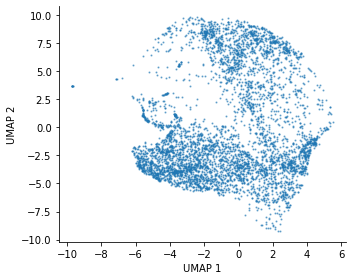

In [104]:
plt.figure(figsize=(5, 4))
plt.scatter(x_sample[:, 0], x_sample[:, 1], marker='.', s=5, alpha=0.5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
sns.despine()
plt.show()

In [105]:
x = umap.transform(profiles.reshape(len(profiles), -1))
x.shape

(83151, 2)

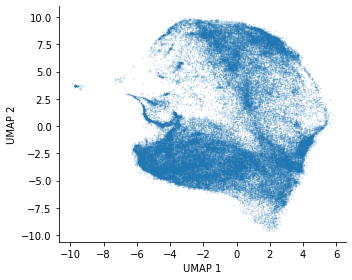

In [106]:
plt.figure(figsize=(5, 4))
plt.scatter(x[:, 0], x[:, 1], marker='.', s=1, alpha=0.2)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
sns.despine()
plt.show()

In [675]:
embedding = x

<IPython.core.display.Javascript object>


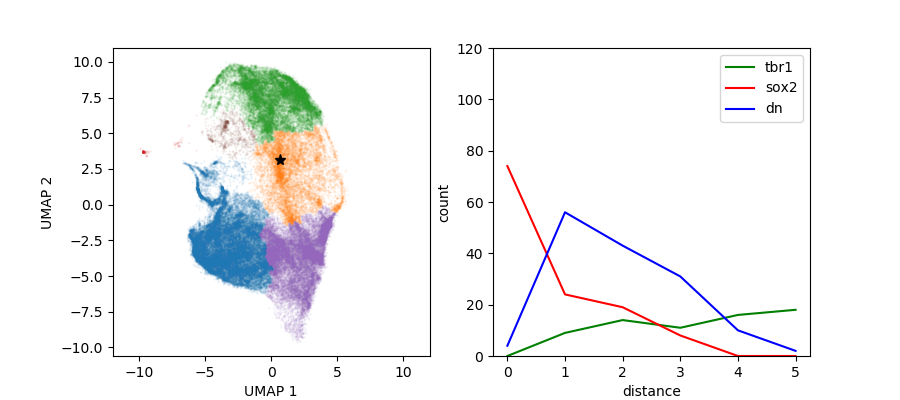

interactive(children=(FloatSlider(value=0.0, description='x', max=12.0, min=-12.0, step=0.05), FloatSlider(val…

In [676]:
%matplotlib notebook

x = -6
y = 4

min_val = -12
max_val = 12

fig = plt.figure(figsize=(9, 4))

ax0 = plt.subplot(121)
for i in range(class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(embedding[idx, 0], embedding[idx, 1], '.', markersize=1, alpha=0.1)
line, = plt.plot(x, y, 'k*', markersize=8)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([min_val, max_val])

ax1 = plt.subplot(122)
ax1.set_ylim([0, 120])

nbrs = NearestNeighbors(1).fit(embedding)
dist, idx = nbrs.kneighbors(np.asarray([[x, y]]))
profile = profiles[idx][0, 0]

names = ['tbr1', 'sox2', 'dn']
colors = ['g', 'r', 'b']
line_profiles = []
for i, p in enumerate(profile):
    line_profile, = plt.plot(p, label=names[i], color=colors[i])
    line_profiles.append(line_profile)
plt.xlabel('distance')
plt.ylabel('count')
plt.legend(loc=1)
    
def update(x=0.0, y=0.0):
    line.set_xdata([x])
    line.set_ydata([y])
    
    _, idx = nbrs.kneighbors(np.asarray([[x, y]]))
    profile = profiles[idx][0, 0]
    for line_profile, p in zip(line_profiles, profile):
        line_profile.set_ydata(p)
    ax1.autoscale_view(None, False, True)
    fig.canvas.draw_idle()
    
interact(update, 
         x=widgets.FloatSlider(min=min_val, max=max_val, step=0.05),
         y=widgets.FloatSlider(min=min_val, max=max_val, step=0.05))

plt.show()

In [107]:
cyto_labels = np.load(os.path.join(working_dir, 'cyto_labels.npy'))
cyto_labels.shape, np.unique(cyto_labels)

((83151,), array([0, 1, 2, 3, 4, 5]))

In [108]:
%matplotlib inline

In [109]:
r = np.arange(len(x))
np.random.shuffle(r)
r = r[:len(r)//4]

x2 = x[r]
cyto_labels2 = cyto_labels[r]

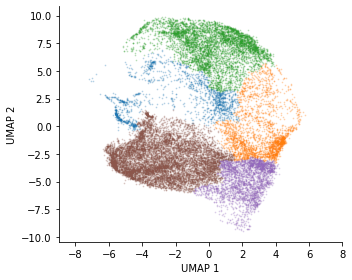

In [110]:
plt.figure(figsize=(5, 4))
for lbl in np.unique(cyto_labels2):
    loc = np.where(cyto_labels2 == lbl)[0]
    sns.scatterplot(x2[loc, 0], x2[loc, 1], marker='.', s=5, alpha=0.2, edgecolor=None)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([-9, 8])
plt.tight_layout()
sns.despine()

# plt.savefig(os.path.join(working_dir, 'single_org_UMAP_clusters.pdf'), bbox_inches='tight')
plt.show()

Cluster cytos in one org (skip)

In [289]:
from sklearn.cluster import AgglomerativeClustering

In [291]:
clustering = AgglomerativeClustering(n_clusters=6, linkage='average').fit(x) # 8, 9, 10
labels = clustering.labels_

class_labels = np.unique(labels)
class_labels

array([0, 1, 2, 3, 4, 5])

W1106 05:01:37.765637 140328294500160 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


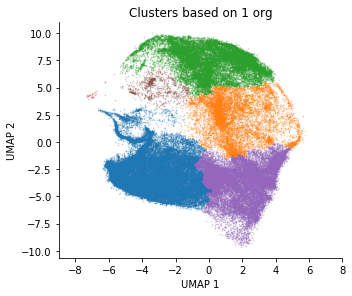

In [325]:
plt.figure(figsize=(5, 4))
for lbl in np.unique(labels):
    loc = np.where(labels == lbl)[0]
    sns.scatterplot(x[loc, 0], x[loc, 1], marker='.', s=4, alpha=0.2, edgecolor=None)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([-9, 8])
plt.tight_layout()
sns.despine()
plt.title('Clusters based on 1 org')
plt.show()

Now that we have the UMAP plot for 1 d35 org, we need example images from each cluster

In [111]:
cluster_idxs = [np.where(cyto_labels == lbl)[0] for lbl in np.unique(cyto_labels)]
cluster_centroids = np.asarray([x[idx].mean(axis=0) for idx in cluster_idxs])
cluster_centroids

array([[-2.0116527 ,  2.5314333 ],
       [ 3.026554  , -0.44481668],
       [ 0.14373752,  7.2216244 ],
       [-9.655646  ,  3.698881  ],
       [ 2.1351953 , -4.8548803 ],
       [-2.7098613 , -2.9272923 ]], dtype=float32)

In [130]:
cluster_centroids[0] = np.array([0, 2.5])
cluster_centroids[4] = np.array([2.5, -8])

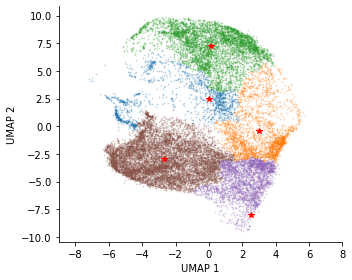

In [131]:
plt.figure(figsize=(5, 4))
for lbl in np.unique(cyto_labels2):
    loc = np.where(cyto_labels2 == lbl)[0]
    sns.scatterplot(x2[loc, 0], x2[loc, 1], marker='.', s=5, alpha=0.2, edgecolor=None)
plt.plot(cluster_centroids[:, 0], cluster_centroids[:, 1], 'r*')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([-9, 8])
plt.tight_layout()
sns.despine()
plt.show()

In [132]:
nbrs = NearestNeighbors(n_neighbors=10).fit(x)
dist, index = nbrs.kneighbors(cluster_centroids)

index.shape

(6, 10)

In [133]:
syto = io.open(os.path.join(working_dir, 'dataset/syto.zarr'))
sox2 = io.open(os.path.join(working_dir, 'dataset/sox2.zarr'))
tbr1 = io.open(os.path.join(working_dir, 'dataset/tbr1.zarr'))

syto.shape

(900, 3794, 3794)

In [134]:
mesh = cyto.load_mesh(os.path.join(working_dir, 'dataset/mesh_ventricles.pkl'))
normal = mesh['normals']
verts_um = mesh['verts']

In [135]:
voxelsize = np.asarray(utils.read_voxel_size(os.path.join(working_dir, 'dataset/voxel_size.csv')))
verts_coord = (verts_um / voxelsize).astype(np.int)
verts_coord.shape

(83151, 3)

In [136]:
cluster_names = utils.read_csv(os.path.join(working_dir, 'cyto_names.csv'))
cluster_names

['TBR1-LowDN', 'TBR1-HighDN', 'Surface', 'Artifacts', 'DN', 'Adjacent']

In [137]:
np.unique(cyto_labels)

array([0, 1, 2, 3, 4, 5])

In [138]:
celltype_names = utils.read_csv(os.path.join(working_dir, 'dataset/celltype_names.csv'))
celltype_names

['sox2', 'tbr1', 'dn']

In [139]:
vol = np.pi * (50/2) ** 2 * 50 / 1000**3

Max density for SOX2: 7.99e+05
Max density for DN: 7.99e+05
Max density for TBR1: 4.00e+05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


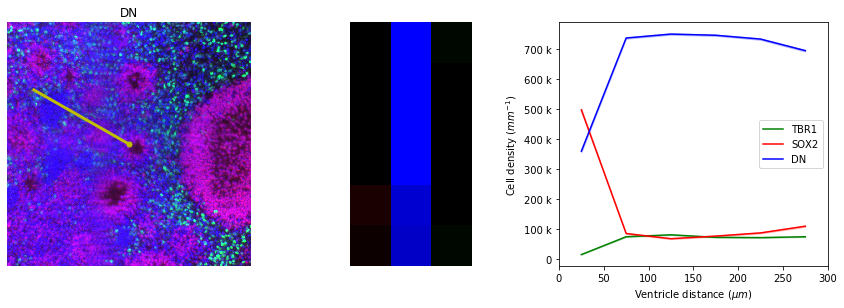

In [152]:
width = 1024
nbr_idx = [2, 8, 6, 5, 1, 9]  # ?, 0, 6, 5, 
nbr_idx = [None, None, None, None, 5, None]  # ?, 8, 6, 5, 

dn_scale = 3.25
sox2_scale = 3.25
tbr1_scale = 6.5

max_count_dn = (255 / dn_scale)
max_count_sox2 = (255 / sox2_scale)
max_count_tbr1 = (255 / tbr1_scale)

max_density_dn = max_count_dn / vol
max_density_sox2 = max_count_sox2 / vol
max_density_tbr1 = max_count_tbr1 / vol

print(f'Max density for SOX2: {max_density_sox2:.2e}')
print(f'Max density for DN: {max_density_dn:.2e}')
print(f'Max density for TBR1: {max_density_tbr1:.2e}')

ticker = matplotlib.ticker.EngFormatter(unit='')

plt.figure(figsize=(12, 24))

p = 1
for lbl, nbr in enumerate(nbr_idx):
    if nbr is None:
        continue
    idx = index[lbl, nbr]
    n = normal[idx]
    v = verts_coord[idx]
    profile = profiles[idx]

    start = np.array([v[0], v[1] - width // 2, v[2] - width // 2])
    stop = np.array([v[0] + 1, v[1] + width // 2, v[2] + width // 2])
    syto_roi = utils.extract_box(syto, start, stop)[0]
    sox2_roi = utils.extract_box(sox2, start, stop)[0]
    tbr1_roi = utils.extract_box(tbr1, start, stop)[0]

    plt.subplot(len(nbr_idx), 3, p)
    plt.imshow(np.dstack([sox2_roi, tbr1_roi, syto_roi ]))
    plt.plot([width // 2, n[2] * 300/voxelsize[2] + width // 2], 
             [width // 2, n[1] * 300/voxelsize[1] + width // 2], 
             'y-', linewidth=3)
    plt.plot([width // 2], [width // 2], 'y.', markersize=10)
    plt.axis('off')
    plt.title(f'{cluster_names[lbl]}')
    
    # Color codes
    ax = plt.subplot(len(nbr_idx), 3, p+1)
    vol = np.pi * 25**2 * 50 / 1000**3
    colorcode = np.zeros((6, 3, 3), np.int)
    colorcode[:, 0, 0] = profile[1] * sox2_scale
    colorcode[:, 2, 1] = profile[0] * tbr1_scale
    colorcode[:, 1, 2] = profile[2] * dn_scale
    plt.imshow(colorcode, origin='bottom')
    plt.axis('off')
    
    # Cell densities (average profiles)
    cluster_profiles = profiles[np.where(cyto_labels == lbl)[0]]
    positions = np.tile(25 + 50 * np.arange(profiles.shape[-1]), (len(cluster_profiles), 1))
    
    ax = plt.subplot(len(nbr_idx), 3, p+2)
    vol = np.pi * 25**2 * 50 / 1000**3
    sns.lineplot(x=positions.ravel(), y=cluster_profiles[:, 0].ravel()/vol, label='TBR1', color='g')
    sns.lineplot(x=positions.ravel(), y=cluster_profiles[:, 1].ravel()/vol, label='SOX2', color='r')
    sns.lineplot(x=positions.ravel(), y=cluster_profiles[:, 2].ravel()/vol, label='DN', color='b')
    ax.yaxis.set_major_formatter(ticker)
    plt.xlim([0, 300])
    plt.ylabel('Cell density ($mm^{-1}$)')
    plt.xlabel('Ventricle distance ($\mu m$)')
    
    p += 3

plt.tight_layout()

plt.savefig(os.path.join(working_dir, 'single_org_cytos_DN_example.pdf'))
plt.show()

In [638]:
colorcodes = np.asarray([np.dstack([p[1], p[0], p[2]]).transpose((1, 0, 2)) for p in profiles])
colorcodes.shape

(83151, 6, 1, 3)

In [639]:
sortidx = np.argsort(cyto_labels)
colorcodes_sorted = colorcodes[sortidx]
colorcodes_sorted.shape

(83151, 6, 1, 3)

In [655]:
N = 100
even_idx = np.round(np.linspace(0, len(colorcodes_sorted)-1, N)).astype(np.int)
colorcodes_sample = colorcodes_sorted[even_idx]
colorcodes_sample.shape

(100, 6, 1, 3)

In [656]:
colorcode_img = colorcodes_sample.transpose((2, 0, 1, 3))[0]
colorcode_img.shape

(100, 6, 3)

W1106 09:32:31.119676 140328294500160 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max density for SOX2: 7.99e+05
Max density for DN: 7.99e+05
Max density for TBR1: 4.00e+05


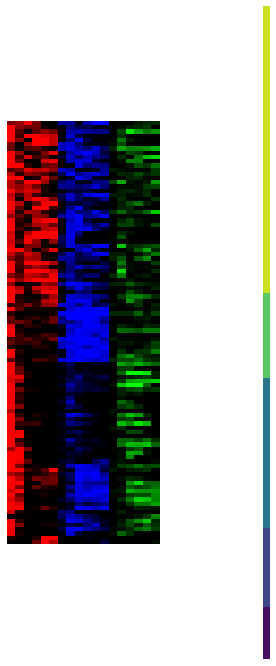

In [663]:
dn_scale = 3.25
sox2_scale = 3.25
tbr1_scale = 6.5

max_count_dn = (255 / dn_scale)
max_count_sox2 = (255 / sox2_scale)
max_count_tbr1 = (255 / tbr1_scale)

max_density_dn = max_count_dn / vol
max_density_sox2 = max_count_sox2 / vol
max_density_tbr1 = max_count_tbr1 / vol

print(f'Max density for SOX2: {max_density_sox2:.2e}')
print(f'Max density for DN: {max_density_dn:.2e}')
print(f'Max density for TBR1: {max_density_tbr1:.2e}')



colorcode_imgflat = np.zeros((len(colorcode_img), colorcode_img.shape[1]*colorcode_img.shape[2], 3), np.int)
colorcode_imgflat[:, :6, 0] = colorcode_img[:, :, 0] * sox2_scale
colorcode_imgflat[:, 6:12, 2] = colorcode_img[:, :, 2] * dn_scale
colorcode_imgflat[:, 12:, 1] = colorcode_img[:, :, 1] * tbr1_scale


plt.figure(figsize=(6, 12))
plt.subplot(121)
plt.imshow(colorcode_imgflat, origin='bottom', aspect=0.5)
plt.axis('off')
plt.subplot(122)
plt.imshow(np.sort(cyto_labels)[even_idx, np.newaxis]*45+10, origin='bottom', clim=[0, 255])
plt.axis('off')

plt.savefig(os.path.join(working_dir, 'single_org_cyto_spectrum.pdf'), bbox_inches='tight')

plt.show()

*Everything below is an attempt to construct a set of features for embedding that are more discriminative*

## Moment analysis of profiles instead of directly embeding counts

In [58]:
counts = profiles.sum(axis=-1)
counts.shape

(83151, 3)

In [59]:
model = UMAP().fit(counts)
x_counts = model.transform(counts)

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../../.conda/envs/scout/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make

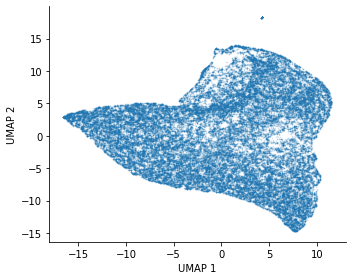

In [60]:
plt.figure(figsize=(5, 4))
plt.scatter(x_counts[:, 0], x_counts[:, 1], marker='.', s=1, alpha=0.2)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
sns.despine()
plt.show()

In [62]:
pos = np.arange(profiles.shape[-1])
pos

array([0, 1, 2, 3, 4, 5])

In [70]:
mean_pos = (pos * profiles).sum(axis=-1) / np.clip(counts, 1, None)
mean_pos.shape

(83151, 3)

In [71]:
model = UMAP().fit(mean_pos)
x_mean_pos = model.transform(mean_pos)

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/scout/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


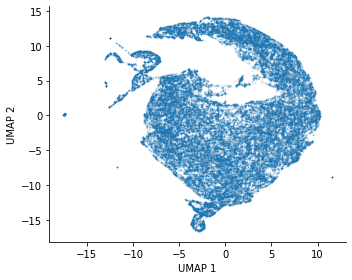

In [72]:
plt.figure(figsize=(5, 4))
plt.scatter(x_mean_pos[:, 0], x_mean_pos[:, 1], marker='.', s=1, alpha=0.2)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
sns.despine()
plt.show()

In [87]:
var_pos = (pos**2 * profiles).sum(axis=-1) / np.clip(counts, 1, None)
var_pos.shape

(83151, 3)

In [88]:
model = UMAP().fit(var_pos)
x_var_pos = model.transform(var_pos)

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/scout/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


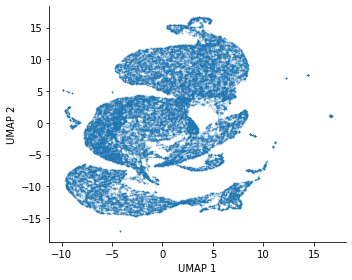

In [89]:
plt.figure(figsize=(5, 4))
plt.scatter(x_var_pos[:, 0], x_var_pos[:, 1], marker='.', s=1, alpha=0.2)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
sns.despine()
plt.show()

<IPython.core.display.Javascript object>


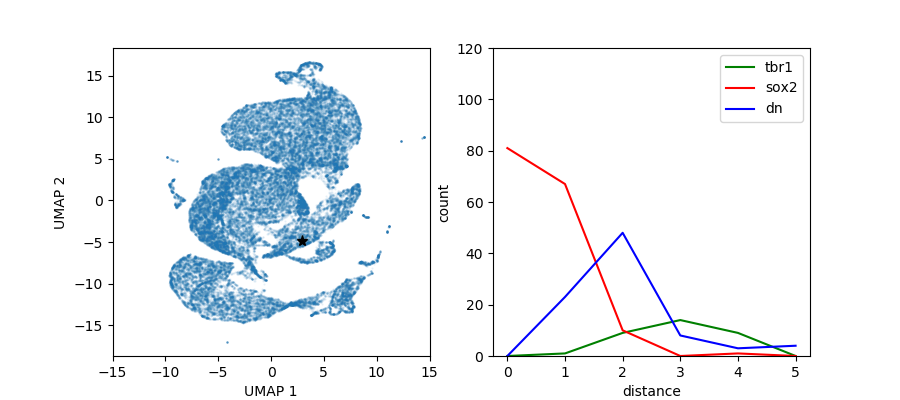

interactive(children=(FloatSlider(value=0.0, description='x', max=15.0, min=-15.0, step=0.05), FloatSlider(val…

In [261]:
%matplotlib notebook

x = -6
y = 4

min_val = -15
max_val = 15

embedding = x_var_pos

fig = plt.figure(figsize=(9, 4))

ax0 = plt.subplot(121)
for i in range(class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(embedding[idx, 0], embedding[idx, 1], '.', markersize=1, alpha=0.1)
line, = plt.plot(x, y, 'k*', markersize=8)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([min_val, max_val])

ax1 = plt.subplot(122)
ax1.set_ylim([0, 120])

nbrs = NearestNeighbors(1).fit(embedding)
dist, idx = nbrs.kneighbors(np.asarray([[x, y]]))
profile = profiles[idx][0, 0]

names = ['tbr1', 'sox2', 'dn']
colors = ['g', 'r', 'b']
line_profiles = []
for i, p in enumerate(profile):
    line_profile, = plt.plot(p, label=names[i], color=colors[i])
    line_profiles.append(line_profile)
plt.xlabel('distance')
plt.ylabel('count')
plt.legend(loc=1)
    
def update(x=0.0, y=0.0):
    line.set_xdata([x])
    line.set_ydata([y])
    
    _, idx = nbrs.kneighbors(np.asarray([[x, y]]))
    profile = profiles[idx][0, 0]
    for line_profile, p in zip(line_profiles, profile):
        line_profile.set_ydata(p)
    ax1.autoscale_view(None, False, True)
    fig.canvas.draw_idle()
    
interact(update, 
         x=widgets.FloatSlider(min=min_val, max=max_val, step=0.05),
         y=widgets.FloatSlider(min=min_val, max=max_val, step=0.05))

plt.show()

In [117]:
fractions = counts / np.clip(counts.sum(axis=-1)[:, np.newaxis], 1, None)
fractions.shape

(83151, 3)

In [118]:
from sklearn.preprocessing import StandardScaler

In [138]:
X = np.concatenate([profiles.reshape((len(profiles), -1)), counts, mean_pos, var_pos], axis=-1)
X.shape

(83151, 27)

In [139]:
scaler = StandardScaler().fit(X)
scaler.mean_

array([  1.05940999,   8.1286094 ,   9.23886664,   7.25441666,
         6.06438888,   5.78659307,  66.14013061,  29.29007468,
        18.63539825,  22.76625657,  22.96501545,  20.76587173,
        14.56324037,  41.55554353,  40.17209655,  32.25879424,
        29.1748626 ,  27.5459345 ,  37.53228464, 180.56274729,
       185.27047179,   2.38086241,   1.46456871,   2.24732668,
         8.03429971,   5.20788663,   7.34877255])

In [140]:
X_norm = scaler.transform(X)

In [141]:
x_feat = UMAP().fit_transform(X_norm)
x_feat.shape

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/scout/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


(83151, 2)

<IPython.core.display.Javascript object>


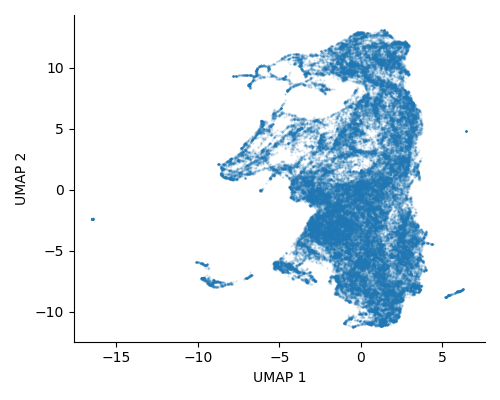

In [142]:
plt.figure(figsize=(5, 4))
plt.scatter(x_feat[:, 0], x_feat[:, 1], marker='.', s=1, alpha=0.2)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
sns.despine()
plt.show()

In [143]:
from sklearn.neighbors import NearestNeighbors
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [144]:
class_labels = np.zeros(1, np.int)
labels = np.zeros(len(x_feat))

<IPython.core.display.Javascript object>


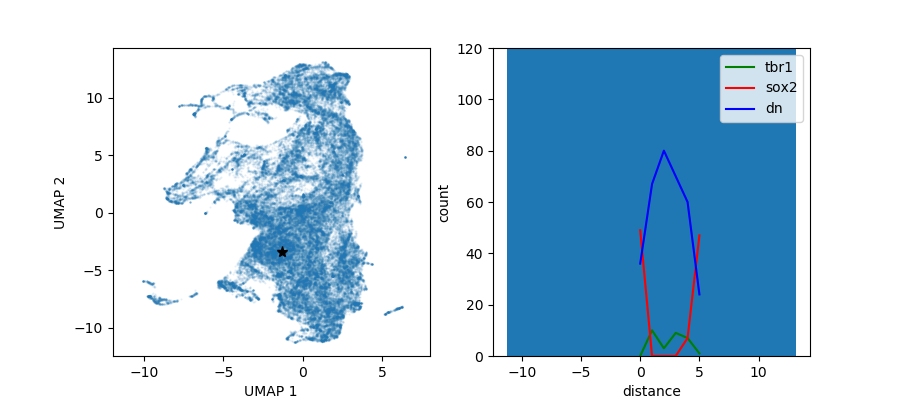

interactive(children=(FloatSlider(value=0.0, description='x', max=8.0, min=-12.0, step=0.05), FloatSlider(valu…

In [148]:
%matplotlib notebook

x = -6
y = 4

min_val = -12
max_val = 8

embedding = x_feat

fig = plt.figure(figsize=(9, 4))

ax0 = plt.subplot(121)
for i in range(class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(embedding[idx, 0], embedding[idx, 1], '.', markersize=1, alpha=0.1)
line, = plt.plot(x, y, 'k*', markersize=8)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([min_val, max_val])

ax1 = plt.subplot(122)
ax1.set_ylim([0, 120])

nbrs = NearestNeighbors(1).fit(embedding)
dist, idx = nbrs.kneighbors(np.asarray([[x, y]]))
profile = profiles[idx][0, 0]

names = ['tbr1', 'sox2', 'dn']
colors = ['g', 'r', 'b']
line_profiles = []
for i, p in enumerate(profile):
    line_profile, = plt.plot(p, label=names[i], color=colors[i])
    line_profiles.append(line_profile)
plt.xlabel('distance')
plt.ylabel('count')
plt.legend(loc=1)
    
def update(x=0.0, y=0.0):
    line.set_xdata([x])
    line.set_ydata([y])
    
    _, idx = nbrs.kneighbors(np.asarray([[x, y]]))
    profile = profiles[idx][0, 0]
    for line_profile, p in zip(line_profiles, profile):
        line_profile.set_ydata(p)
    ax1.autoscale_view(None, False, True)
    fig.canvas.draw_idle()
    
interact(update, 
         x=widgets.FloatSlider(min=min_val, max=max_val, step=0.05),
         y=widgets.FloatSlider(min=min_val, max=max_val, step=0.05))

plt.show()

<IPython.core.display.Javascript object>


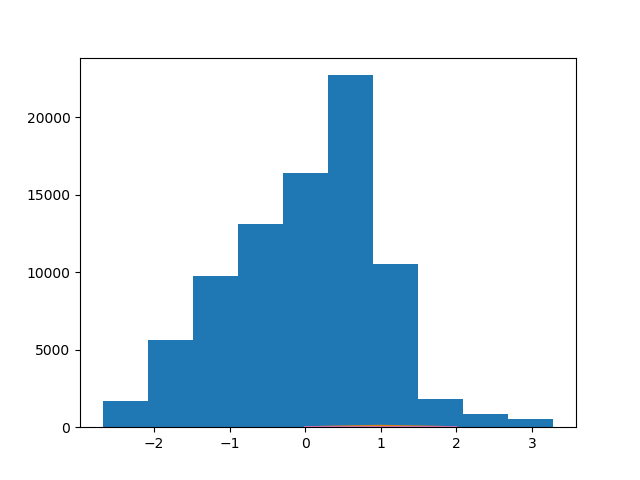

(array([ 1711.,  5619.,  9783., 13103., 16435., 22722., 10560.,  1833.,
          846.,   539.]),
 array([-2.68228264, -2.08551078, -1.48873892, -0.89196706, -0.29519521,
         0.30157665,  0.89834851,  1.49512037,  2.09189222,  2.68866408,
         3.28543594]),
 <a list of 10 Patch objects>)

In [156]:
plt.hist(X_norm[:, -4])

In [160]:
profiles.shape

(83151, 3, 6)

## Autoencoder representation learning

In [157]:
import tensorflow as tf

In [235]:
x_in = tf.keras.layers.Input(shape=(6, 3))

x = tf.keras.layers.Conv1D(8, 3, padding='same', activation='relu')(x_in)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(2)(x)
x = tf.keras.layers.Conv1D(16, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x_embed = tf.keras.layers.Dense(24, activation='linear')(x)
x = tf.keras.layers.Reshape((3, 8))(x_embed)
x = tf.keras.layers.UpSampling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(4, 3, padding='same', activation='relu')(x)
x_out = tf.keras.layers.Conv1D(3, 1, padding='same', activation='linear')(x)

model = tf.keras.Model(x_in, x_out)
encoder = tf.keras.Model(x_in, x_embed)

In [236]:
model.compile('adam', loss='mse')

In [238]:
model.fit(profiles.transpose((0,2,1)), 
          profiles.transpose((0,2,1)),
          epochs=10, batch_size=16)

Epoch 1/10
83151/83151 [==============================] - 64s 775us/sample - loss: 36.9562
Epoch 2/10
83151/83151 [==============================] - 64s 770us/sample - loss: 20.4342
Epoch 3/10
83151/83151 [==============================] - 65s 777us/sample - loss: 15.9889
Epoch 4/10
83151/83151 [==============================] - 65s 776us/sample - loss: 13.7756
Epoch 5/10
83151/83151 [==============================] - 64s 775us/sample - loss: 12.3589
Epoch 6/10
83151/83151 [==============================] - 65s 776us/sample - loss: 11.2888
Epoch 7/10
83151/83151 [==============================] - 65s 777us/sample - loss: 10.6327
Epoch 8/10
83151/83151 [==============================] - 65s 779us/sample - loss: 10.1760
Epoch 9/10
83151/83151 [==============================] - 64s 771us/sample - loss: 9.7173
Epoch 10/10
83151/83151 [==============================] - 64s 774us/sample - loss: 9.4184


In [239]:
pred = model.predict(profiles.transpose((0,2,1)))

In [240]:
ae_feat = encoder.predict(profiles.transpose((0,2,1)))
ae_feat.shape

(83151, 24)

<IPython.core.display.Javascript object>


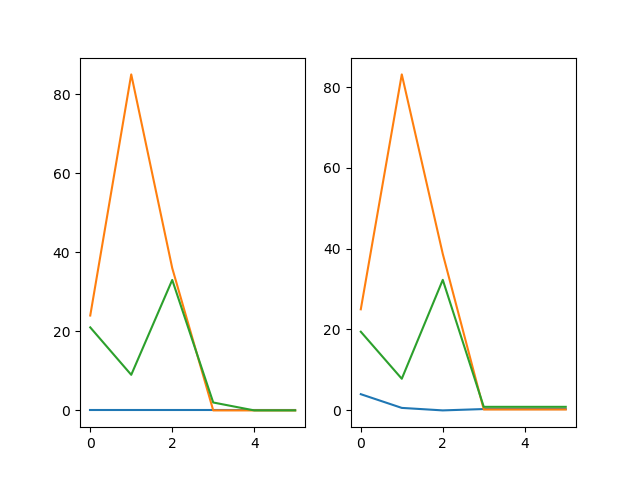

In [245]:
idx = 1000

plt.subplot(121)
plt.plot(profiles[idx].T)
plt.subplot(122)
plt.plot(pred[idx])
plt.show()

In [246]:
from sklearn.decomposition import PCA

In [247]:
ae_pca = PCA(2).fit_transform(ae_feat)
ae_pca.shape

(83151, 2)

<IPython.core.display.Javascript object>


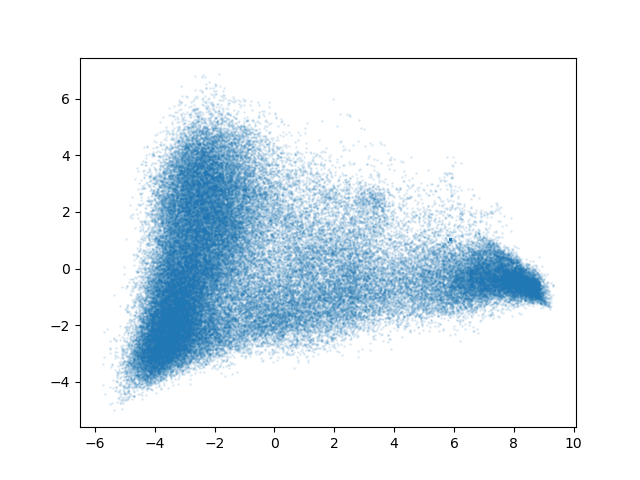

In [248]:
plt.scatter(ae_pca[:, 0], ae_pca[:, 1], s=1, alpha=0.1)

In [249]:
ae_umap = UMAP().fit_transform(ae_feat)
ae_umap.shape

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/scout/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


(83151, 2)

<IPython.core.display.Javascript object>


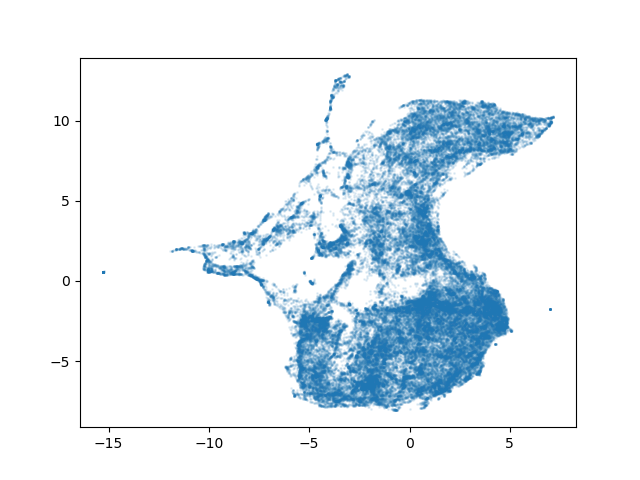

In [250]:
plt.figure()
plt.scatter(ae_umap[:, 0], ae_umap[:, 1], s=1, alpha=0.1)
plt.show()

<IPython.core.display.Javascript object>


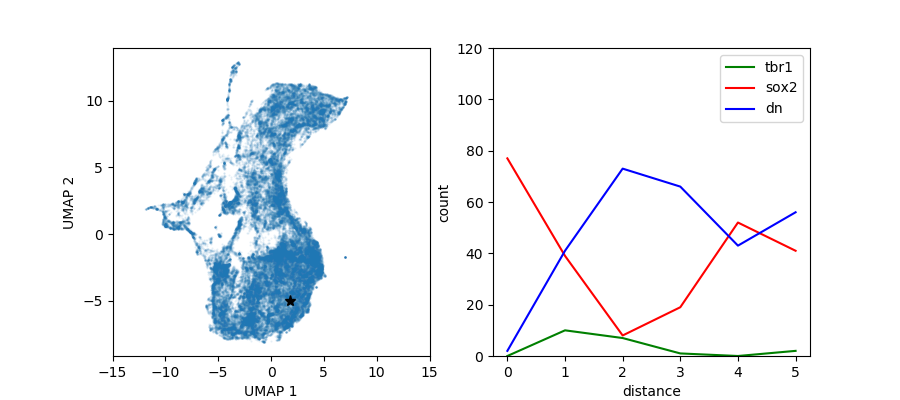

interactive(children=(FloatSlider(value=0.0, description='x', max=15.0, min=-15.0, step=0.05), FloatSlider(val…

In [251]:
%matplotlib notebook

x = -6
y = 4

min_val = -15
max_val = 15

embedding = ae_umap

fig = plt.figure(figsize=(9, 4))

ax0 = plt.subplot(121)
for i in range(class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(embedding[idx, 0], embedding[idx, 1], '.', markersize=1, alpha=0.1)
line, = plt.plot(x, y, 'k*', markersize=8)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([min_val, max_val])

ax1 = plt.subplot(122)
ax1.set_ylim([0, 120])

nbrs = NearestNeighbors(1).fit(embedding)
dist, idx = nbrs.kneighbors(np.asarray([[x, y]]))
profile = profiles[idx][0, 0]

names = ['tbr1', 'sox2', 'dn']
colors = ['g', 'r', 'b']
line_profiles = []
for i, p in enumerate(profile):
    line_profile, = plt.plot(p, label=names[i], color=colors[i])
    line_profiles.append(line_profile)
plt.xlabel('distance')
plt.ylabel('count')
plt.legend(loc=1)
    
def update(x=0.0, y=0.0):
    line.set_xdata([x])
    line.set_ydata([y])
    
    _, idx = nbrs.kneighbors(np.asarray([[x, y]]))
    profile = profiles[idx][0, 0]
    for line_profile, p in zip(line_profiles, profile):
        line_profile.set_ydata(p)
    ax1.autoscale_view(None, False, True)
    fig.canvas.draw_idle()
    
interact(update, 
         x=widgets.FloatSlider(min=min_val, max=max_val, step=0.05),
         y=widgets.FloatSlider(min=min_val, max=max_val, step=0.05))

plt.show()

In [253]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [255]:
ae_tsne = MulticoreTSNE(n_jobs=-1).fit_transform(ae_feat)
ae_tsne

array([[-12.68502519,  27.38177441],
       [-11.09870749,  29.0905786 ],
       [-13.25793828,  23.86793777],
       ...,
       [-22.17258028,  20.14247553],
       [-22.36861594,  21.63364355],
       [-18.07639838,  24.51161977]])

<IPython.core.display.Javascript object>


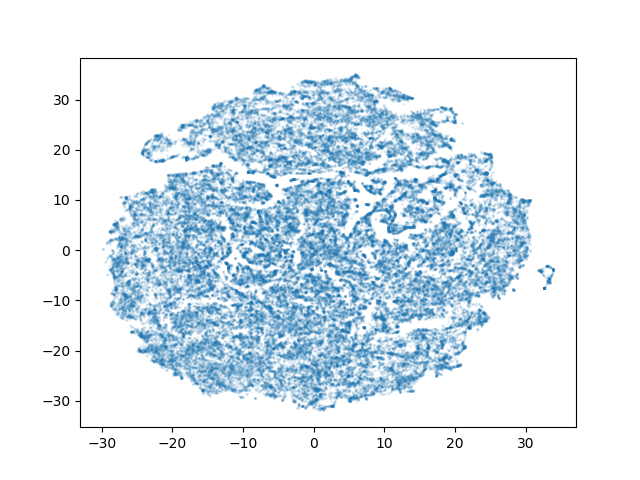

In [256]:
plt.figure()
plt.scatter(ae_tsne[:, 0], ae_tsne[:, 1], s=1, alpha=0.1)
plt.show()

<IPython.core.display.Javascript object>


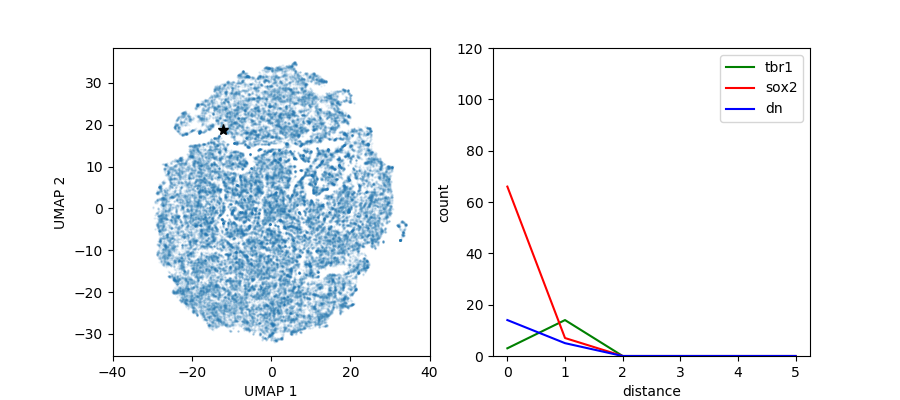

interactive(children=(FloatSlider(value=0.0, description='x', max=40.0, min=-40.0, step=0.05), FloatSlider(val…

In [259]:
%matplotlib notebook

x = -6
y = 4

min_val = -40
max_val = 40

embedding = ae_tsne

fig = plt.figure(figsize=(9, 4))

ax0 = plt.subplot(121)
for i in range(class_labels.max() + 1):
    idx = np.where(labels == i)[0]
    plt.plot(embedding[idx, 0], embedding[idx, 1], '.', markersize=1, alpha=0.1)
line, = plt.plot(x, y, 'k*', markersize=8)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim([min_val, max_val])

ax1 = plt.subplot(122)
ax1.set_ylim([0, 120])

nbrs = NearestNeighbors(1).fit(embedding)
dist, idx = nbrs.kneighbors(np.asarray([[x, y]]))
profile = profiles[idx][0, 0]

names = ['tbr1', 'sox2', 'dn']
colors = ['g', 'r', 'b']
line_profiles = []
for i, p in enumerate(profile):
    line_profile, = plt.plot(p, label=names[i], color=colors[i])
    line_profiles.append(line_profile)
plt.xlabel('distance')
plt.ylabel('count')
plt.legend(loc=1)
    
def update(x=0.0, y=0.0):
    line.set_xdata([x])
    line.set_ydata([y])
    
    _, idx = nbrs.kneighbors(np.asarray([[x, y]]))
    profile = profiles[idx][0, 0]
    for line_profile, p in zip(line_profiles, profile):
        line_profile.set_ydata(p)
    ax1.autoscale_view(None, False, True)
    fig.canvas.draw_idle()
    
interact(update, 
         x=widgets.FloatSlider(min=min_val, max=max_val, step=0.05),
         y=widgets.FloatSlider(min=min_val, max=max_val, step=0.05))

plt.show()